# Time Domain Tutorial #3
## State Space Oscillators for real data

NESS 2023

Emily Stephen

The `data` folder contains three files, each with 30 seconds of 
EEG data from a healthy subject during propofol‑induced unconsciousness:
-  `eeganes07laplac250_detrend_all_t180.mat` Awake, before propofol induction
-  `eeganes07laplac250_detrend_all_t3070.mat` Unconscious, at a low dose of propofol
-  `eeganes07laplac250_detrend_all_t4710.mat` Unconscious, at a high dose of propofol

Propofol anesthesia is characterized by two rhythms꞉ a global slow
wave (<1 Hz) and a frontal alpha rhythm (~10 Hz). In this tutorial:
1. we will use the iterative oscillator framework to discover the rhythms in one channel
2. using the fitted hidden state, we will explore the relationship between the instantaneous amplitude of the alpha and the instantaneous phase of the slow
3. finally, we will use the Common Oscillator Model to find the latent oscillators underlying all of the data, and we will compare the results to the Global coherence


In [1]:
import numpy as np
import scipy
import os.path as op
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity

# From Eden-Kramer-Lab/common_oscillator_models (python branch)
from core_functions.simulated_data import simdata_settings, simulate
from core_functions.core import em_B, get_theoretical_psd_COM

# From mh105/somata
from somata.iterative_oscillator import IterativeOscillatorModel as IterOsc
from somata.iterative_oscillator.helper_functions import simulate_matsuda, sim_to_osc_object

## Load and plot the data

In [2]:
segment_names = ['t180','t3070','t4710']
filepaths = [f'../data/eeganes07laplac250_detrend_all_{tmin}.mat' for 
             tmin in segment_names]

datadicts = []
for name,f in zip(segment_names,filepaths):
    l = scipy.io.loadmat(f,squeeze_me=True)
    l['name'] = name
    datadicts.append(l)
    
Fs = datadicts[0]['Fs']
egrid_0indexed = datadicts[0]['egrid_0indexed']

In [3]:
def convert_grid(vec):
    # Input: 
    #    vec: (64,)
    # Returns:
    #    grid: (9,11) layout of the data in vec using egrid_0indexed
    grid = vec[egrid_0indexed.astype(int)]
    grid[np.isnan(egrid_0indexed)] = np.nan
    return grid

Text(0.5, 1.0, 'Electrode #41')

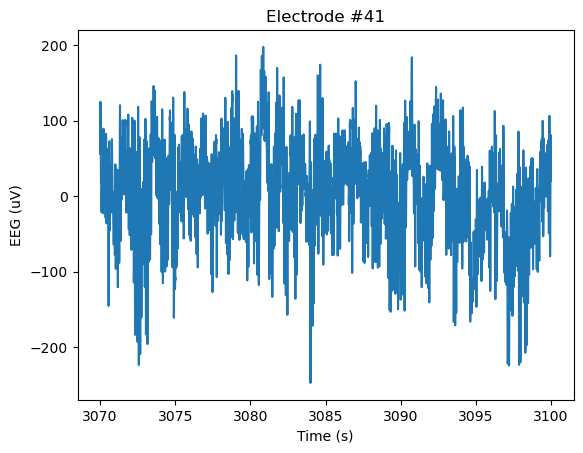

In [4]:
# Pick the low dose condition
y = datadicts[1]['y']
ta = datadicts[1]['ta']

# pick electrode 41
esel = 41

plt.figure()
plt.plot(ta,y[:,esel])
plt.xlabel('Time (s)')
plt.ylabel('EEG (uV)')
plt.title(f'Electrode #{esel}')

In [5]:
# Power spectrum
TW=5
ntapers = 8

m = Multitaper(y,
            sampling_frequency=Fs,
            time_halfbandwidth_product=TW,
            n_tapers=ntapers,
            start_time=ta[0])
c = Connectivity(fourier_coefficients=m.fft(),
            frequencies=m.frequencies,
            time=m.time)
S = c.power().squeeze()
fa = c.frequencies


Text(0.5, 1.0, 'Electrode #41')

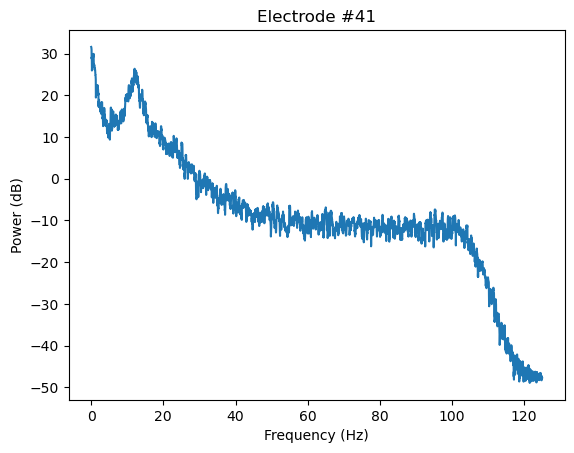

In [6]:
plt.figure()
plt.plot(fa,10*np.log10(S[:,esel]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title(f'Electrode #{esel}')

## 1. Use somata to decompose electrode 41 into its component frequencies

1. Based on the power spectrum, choose the frequency above which there should only be white noise. Use this value as the `noise_start` parameter 
2. Instantiate the Iterative Oscillator object for electrode 41
3. Run the fit (iterate)
4. Plot the likelihood and selected model
5. Plot the results in the time and frequency domain

## 2. Phase Amplitude Coupling

Since the IterOsc didn't decide to model the slow wave with an oscillator, let's build an oscillator object with two oscillators and use EM to fit it.

Here is code to:
1. Build an oscillator object with an oscillation at .5 Hz and 10 Hz
2. Run EM to fit the variances and hidden states

In [10]:
from somata.basic_models import OscillatorModel as Osc

Rinit = np.var(y[:,esel])
o1 = Osc(a=[.996,.95],freq=[0.5,10],sigma2=None,Fs=Fs,y=y[:,esel],R=Rinit)
print(o1)

 nstate   = 4     ncomp    = 2
 nchannel = 1     ntime    = 7500
 nmodel   = 1
 components = [Osc(0)<f700>, Osc(0)<f730>]
 F  .shape = (4, 4)     Q  .shape = (4, 4)
 mu0.shape = (4, 1)     Q0 .shape = (4, 4)
 G  .shape = (1, 4)     R  .shape = (1, 1)
 y  .shape = (1, 7500)  Fs = 250.0 Hz
 damping a = [0.996 0.95 ]
 freq Hz   = [ 0.5 10. ]
 sigma2    = [3. 3.]
 obs noise R = [[4159.34]]
 dc index  = None



Look at the initial settings:

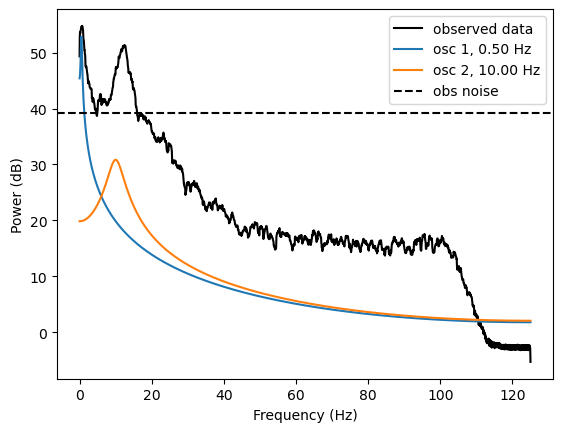

In [11]:
_ = o1.visualize_freq('theoretical', y=io_orig.y_original)
    

Run EM, and look at updated settings

In [12]:
for i in range(20):
    o1.m_estimate(**o1.kalman_filt_smooth(EM=True))

print(o1)

 nstate   = 4     ncomp    = 2
 nchannel = 1     ntime    = 7500
 nmodel   = 1
 components = [Osc(0)<f700>, Osc(0)<f730>]
 F  .shape = (4, 4)     Q  .shape = (4, 4)
 mu0.shape = (4, 1)     Q0 .shape = (4, 4)
 G  .shape = (1, 4)     R  .shape = (1, 1)
 y  .shape = (1, 7500)  Fs = 250.0 Hz
 damping a = [0.997 0.988]
 freq Hz   = [ 0.67 12.19]
 sigma2    = [11.544 47.828]
 obs noise R = [[10.143]]
 dc index  = None



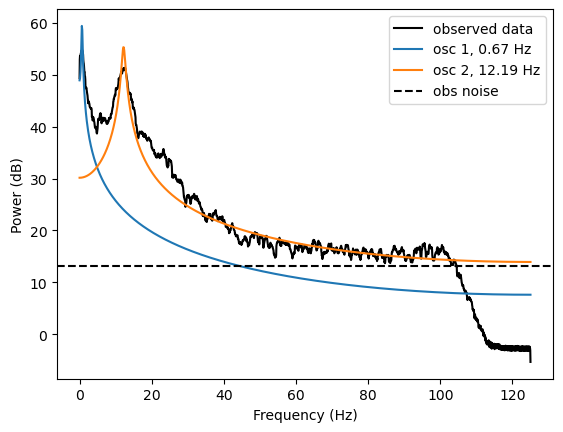

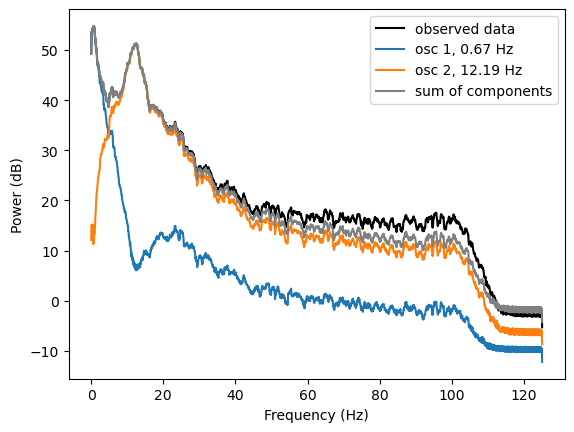

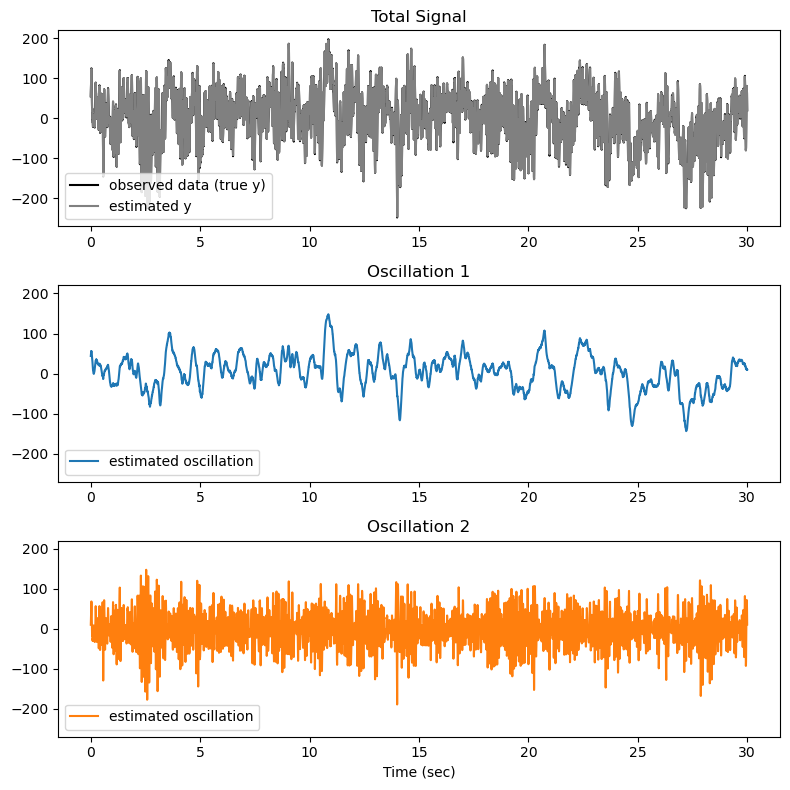

In [13]:
for version in ['theoretical', 'actual']:
    _ = o1.visualize_freq(version, y=io_orig.y_original)
    
# Plot time domain estimated x_t
_ = o1.visualize_time(y=io_orig.y_original)


### Use the fitted oscillations to estimate PAC

1. Plot the slow and alpha hidden states (1) as a timeseries, and (2) as a phasor
2. Plot the instantaneous phase of the slow and the instantaneous amplitude of the alpha, using the following equations:
\begin{equation*}
    \text{amplitude(t)} = \sqrt{(x_{\text{Re}}(t))^2 + (x_{\text{Im}}(t))^2}\\
    \text{phase(t)} = \text{atan2}(x_{\text{Im}}(t),x_{\text{Re}}(t))
\end{equation*}

3. Plot a bar plot of the mean instantaneous amplitude of the alpha as a function of the instantaneous phase of the slow


Bonus ideas:
- Compare the high dose PAC to the low dose PAC. Why would they be called "peak max" and "trough max"? Which one is which?
- Implement the regression framework described here: Soulat, H., Stephen, E. P., Beck, A. M., & Purdon, P. L. (2022). State space methods for phase amplitude coupling analysis. Scientific Reports, 12(1), 15940. [10.1038/s41598-022-18475-3](https://doi.org/10.1038/s41598-022-18475-3)
